In [2]:
# ============================================
# EARLY STAGE DIABETES RISK — MODELLING NOTEBOOK
# ============================================

CSV_PATH = "/content/sample_data/diabetes_data_upload.csv"  # <-- change if needed

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)

print("Libraries loaded.")


Libraries loaded.


In [3]:
# 1) LOAD & QUICK CLEAN
df = pd.read_csv(CSV_PATH)

# Standardize some common labels if present
text_map = {
    "Yes": 1, "No": 0,
    "Male": 1, "Female": 0,
    "Positive": 1, "Negative": 0
}
df_std = df.replace(text_map)

# Ensure Age numeric if needed
if "Age" in df_std.columns and df_std["Age"].dtype == "O":
    age_extracted = df_std["Age"].str.extract(r"(\d+)")[0]
    df_std["Age"] = pd.to_numeric(age_extracted, errors="coerce")

df_std.head()


/tmp/ipython-input-3876587133.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_std = df.replace(text_map)


,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


In [4]:
# 2) DEFINE FEATURES & TARGET
if "class" not in df_std.columns:
    raise ValueError("Target column 'class' not found. Please verify your dataset.")

X = df_std.drop(columns=["class"])
y = df_std["class"]

# Identify columns by dtype for preprocessing
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)
print("Target distribution:\n", y.value_counts(normalize=True))


Categorical columns: []
Numeric columns: ['Age', 'Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring', 'Itching', 'Irritability', 'delayed healing', 'partial paresis', 'muscle stiffness', 'Alopecia', 'Obesity']
Target distribution:
 class
1    0.615385
0    0.384615
Name: proportion, dtype: float64


In [5]:
# 3) TRAIN/TEST SPLIT (stratified to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape


((416, 16), (104, 16))

In [6]:
# 4) PREPROCESSOR
# - OneHotEncode categorical strings (if any)
# - StandardScale numeric (useful for LR/SVM/NN; safe for trees)
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop"
)


LogReg Accuracy: 0.9423076923076923
LogReg F1: 0.9516129032258065

Classification Report (LogReg):
               precision    recall  f1-score   support

           0       0.89      0.97      0.93        40
           1       0.98      0.92      0.95        64

    accuracy                           0.94       104
   macro avg       0.93      0.95      0.94       104
weighted avg       0.95      0.94      0.94       104

LogReg ROC-AUC: 0.990234375


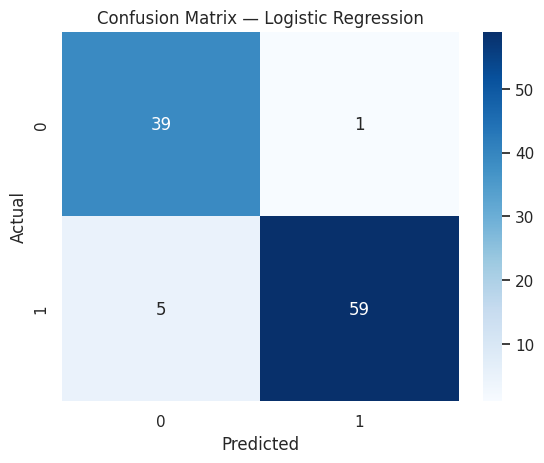

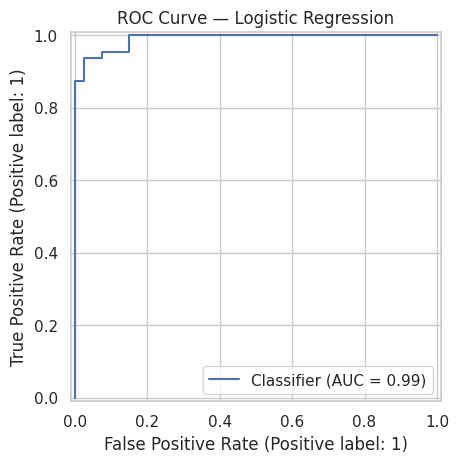

In [7]:
# 5) BASELINE MODEL — LOGISTIC REGRESSION
# (Clear, interpretable; benefits from scaling)
log_reg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=200, n_jobs=None))
])

log_reg.fit(X_train, y_train)
pred_lr = log_reg.predict(X_test)
proba_lr = log_reg.predict_proba(X_test)[:, 1]

print("LogReg Accuracy:", accuracy_score(y_test, pred_lr))
print("LogReg F1:", f1_score(y_test, pred_lr))
print("\nClassification Report (LogReg):\n", classification_report(y_test, pred_lr))

# ROC-AUC (if binary)
try:
    print("LogReg ROC-AUC:", roc_auc_score(y_test, proba_lr))
except Exception:
    pass

cm_lr = confusion_matrix(y_test, pred_lr)
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

try:
    RocCurveDisplay.from_predictions(y_test, proba_lr)
    plt.title("ROC Curve — Logistic Regression")
    plt.show()
except Exception:
    pass


RF Accuracy: 0.9807692307692307
RF F1: 0.984375

Classification Report (RF):
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        40
           1       0.98      0.98      0.98        64

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

RF ROC-AUC: 0.9988281250000001


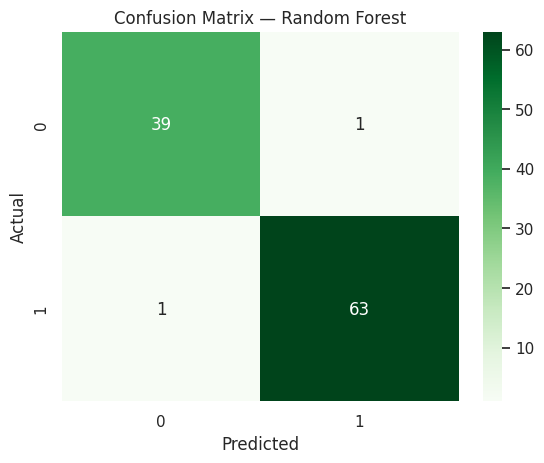

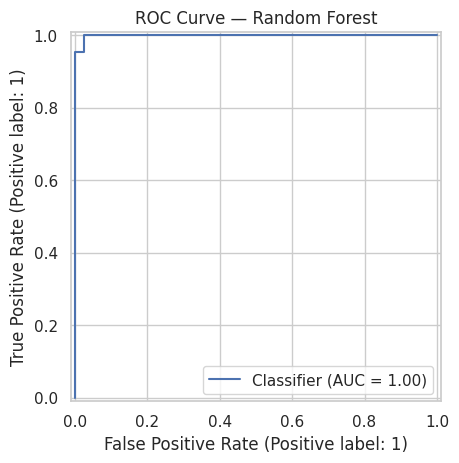

In [8]:
# 6) ROBUST MODEL — RANDOM FOREST
# (Works well with mixed/binary features, minimal tuning)
rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1
    ))
])

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

# Some RF implementations expose predict_proba; ColumnTransformer keeps feature space
try:
    proba_rf = rf.predict_proba(X_test)[:, 1]
except Exception:
    # If not available (should be), fake uniform probs to keep code safe
    proba_rf = np.full_like(y_test, fill_value=float(np.mean(y_train)), dtype=float)

print("RF Accuracy:", accuracy_score(y_test, pred_rf))
print("RF F1:", f1_score(y_test, pred_rf))
print("\nClassification Report (RF):\n", classification_report(y_test, pred_rf))

try:
    print("RF ROC-AUC:", roc_auc_score(y_test, proba_rf))
except Exception:
    pass

cm_rf = confusion_matrix(y_test, pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix — Random Forest")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

try:
    RocCurveDisplay.from_predictions(y_test, proba_rf)
    plt.title("ROC Curve — Random Forest")
    plt.show()
except Exception:
    pass


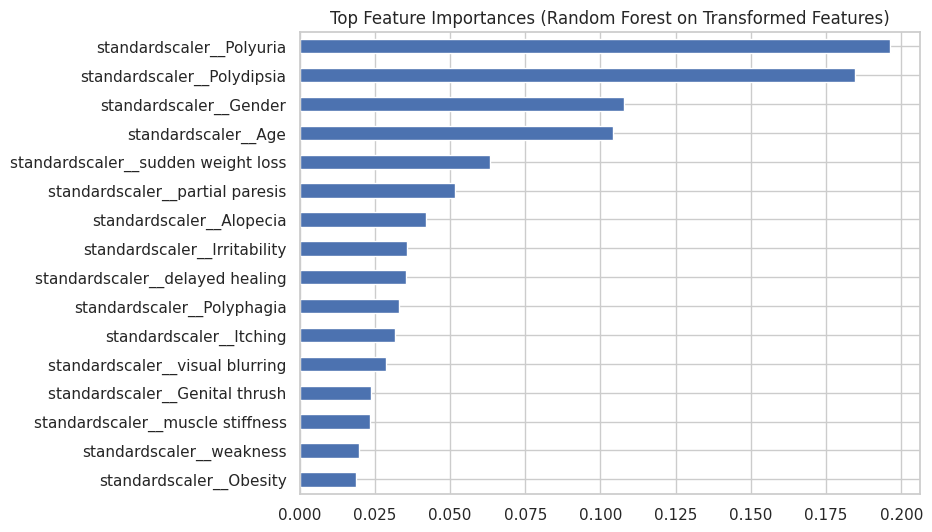

,0
standardscaler__Polyuria,0.196322
standardscaler__Polydipsia,0.184587
standardscaler__Gender,0.107943
standardscaler__Age,0.104262
standardscaler__sudden weight loss,0.063437
standardscaler__partial paresis,0.051522
standardscaler__Alopecia,0.042030
standardscaler__Irritability,0.035699
standardscaler__delayed healing,0.035277
standardscaler__Polyphagia,0.032932


In [9]:
# 7) SIMPLE FEATURE IMPORTANCE (model-dependent)
# We'll refit a standalone RF on preprocessed numeric data to extract importances cleanly.
# For a production approach, keep track of one-hot feature names; here we keep it simple.

# Create fully transformed train to get feature names for OHE + scaler
ohe = OneHotEncoder(handle_unknown="ignore")
scaler = StandardScaler()

from sklearn.compose import make_column_transformer
from sklearn import set_config
set_config(transform_output="pandas")  # so we get a DataFrame back with column names

ct = make_column_transformer(
    (ohe, cat_cols),
    (scaler, num_cols),
    remainder="drop"
)

Xtr_df = ct.fit_transform(X_train)
rf_raw = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
rf_raw.fit(Xtr_df, y_train)

importances = pd.Series(rf_raw.feature_importances_, index=Xtr_df.columns).sort_values(ascending=True)

plt.figure(figsize=(8, max(6, 0.3*len(importances))))
importances.tail(20).plot(kind="barh")
plt.title("Top Feature Importances (Random Forest on Transformed Features)")
plt.show()

display(importances.sort_values(ascending=False).head(20))


In [10]:
# 8) SUMMARY & NEXT STEPS
print(f"""
SUMMARY
-------
• We trained two models:
  - Logistic Regression (interpretable baseline, scales features)
  - Random Forest (robust, low-prep)
• Metrics show how well each model predicted diabetes risk on unseen data.
• Confusion matrices reveal where models make mistakes.
• Feature importance highlights strong indicators (e.g., Polyuria, Polydipsia, Sudden weight loss, etc.).

NEXT STEPS
----------
• If required, try class-weight balancing or thresholds optimization.
• Consider calibration if you need reliable probabilities.
• Package the best pipeline (preprocess + model) for inference.
""")



SUMMARY
-------
• We trained two models:
  - Logistic Regression (interpretable baseline, scales features)
  - Random Forest (robust, low-prep)
• Metrics show how well each model predicted diabetes risk on unseen data.
• Confusion matrices reveal where models make mistakes.
• Feature importance highlights strong indicators (e.g., Polyuria, Polydipsia, Sudden weight loss, etc.).

NEXT STEPS
----------
• If required, try class-weight balancing or thresholds optimization.
• Consider calibration if you need reliable probabilities.
• Package the best pipeline (preprocess + model) for inference.

